In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from random import normalvariate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import os
import pickle
from urllib import request
import gzip
import pandas as pd
import seaborn as sns
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'

# Part 2: Scalar backpropagation

## Question 3

Implement the network drawn in the image below, including the weights. Perform one forward pass, up to the loss on the target value, and one backward pass. Show the relevant code in your report. Report the derivatives on all weights (including biases). Do not use anything more than plain python and the math package.

In [2]:
def initialize():
    w = [[1.,1.,1.], [-1.,-1.,-1.]]
    b = [0.,0.,0.]
    v = [[1.,1.],[-1.,-1.],[-1.,-1.]]
    c = [0., 0.]
    
    return w,b,v,c

def linear(w, b, x0, length):
    k = [0.]*length
    for j in range(len(k)):
        for i in range(len(x0)):
            k[j] += w[i][j] * x0[i]
        k[j] += b[j]
    return k

def sigmoid(x):
    return 1. / (1. + math.exp(-x))

def softmax(z):
    temp = [math.e**x for x in z ]
    b =  sum([math.e**x for x in z])
    c = [x/b for x in temp]
    return c

def loss(pred, y):
    l = 0.0
    for i in range(len(pred)): # Loop through output layer
        l += y[i] * (-math.log(pred[i]))
    return l

def sigmoid_list(lista):
    h = len(lista)* [0]
    for i in range(len(lista)):
        h[i] = sigmoid(lista[i])
    return h


def forward_pass(w, b, x0, v, c, y):
    k1 = linear(w, b, x0, 3) #linear first layer and bias
    h = sigmoid_list(k1) #first layer after sigmoid activation
    k2 = linear(v, c, h, 2) #linear second layer and bias
    pred = softmax(k2) #softmax
    return h, pred


def initialize_grads():
    dv = [[0.0, 0.0],[0.0, 0.0],[0.0, 0.0]]
    dh = [0.0, 0.0, 0.0]
    dk = [0.0, 0.0, 0.0]
    db = [0.0, 0.0, 0.0]
    dw = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    dy = [0.,0.]
    return dv, dh, dk, dw, db, dy

def backpropagate_scalar(x0, pred, y, v, h):
    dv, dh, dk, dw, db, dy = initialize_grads()
    
    for pr in range(len(pred)):
        dy[pr] = pred[pr] - y[pr]

    for i in range(len(h)):
        for j in range(len(dy)):
            dv[i][j] = dy[j] * h[i]  # derivative of V
            dh[i] += dy[j] * v[i][j]  # derivative of H

    dc = dy.copy() # Assign dC to the parameters dict

    for i in range(len(h)):
        dk[i] = dh[i]*h[i]*(1-h[i]) #derivative using sigmoid property

    for j in range(len(dk)):
        for i in range(len(x0)):
            dw[i][j] = dk[j] * x0[i] # derivative of W
        db[j] = dk[j]

    return dy, dv, dh, dk, dw, db, dc


## Question 4

Implement a training loop for your network and show that the training loss drops as training progresses.

In [3]:
def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

Epoch  0 , Loss:  0.3962622336592722
Epoch  1 , Loss:  0.13095350095861596
Epoch  2 , Loss:  0.06460646355171497
Epoch  3 , Loss:  0.04047491563105067
Epoch  4 , Loss:  0.027202922947086938
Epoch  5 , Loss:  0.01849705659259788
Epoch  6 , Loss:  0.012839270776536904
Epoch  7 , Loss:  0.00921262314760744
Epoch  8 , Loss:  0.006836197976857687
Epoch  9 , Loss:  0.005220547824927244
Epoch  10 , Loss:  0.004081164147372589
Epoch  11 , Loss:  0.003251944741468237
Epoch  12 , Loss:  0.002632665396708786
Epoch  13 , Loss:  0.0021604134551736283
Epoch  14 , Loss:  0.001794138127007651
Epoch  15 , Loss:  0.0015060765027756864
Epoch  16 , Loss:  0.001276838509517484
Epoch  17 , Loss:  0.0010924988090154142
Epoch  18 , Loss:  0.000942823251005633
Epoch  19 , Loss:  0.0008201533851791733
Epoch  20 , Loss:  0.000718681191014383
Epoch  21 , Loss:  0.0006339604201529501
Epoch  22 , Loss:  0.0005625653328988171
Epoch  23 , Loss:  0.0005018445017009348
Epoch  24 , Loss:  0.0004497385677360603
Epoch  25

No handles with labels found to put in legend.


Epoch  39 , Loss:  0.00011325044147962712


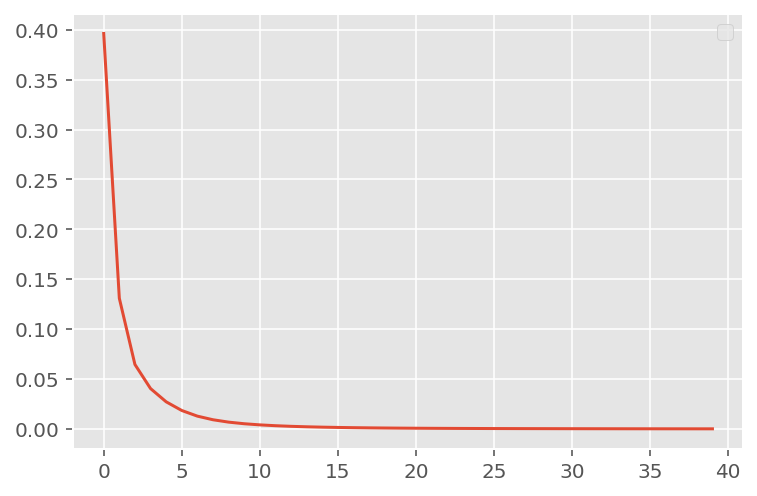

In [4]:
def update_parameters_scalar(v, c, w, b, dv, dc, dw, db, alpha: float):
    n_x, n_h, n_y = 2, 3, 2 #sizes
    
    for i in range(n_y): #output layer
        for j in range(n_h): #hidden layer
            v[j][i] -= alpha * dv[j][i]  #update second layer of weights 
        c[i] -= alpha * dc[i]  #update second layer bias

    for i in range(n_h): #hidden layer
        for j in range(n_x): #input layer
            w[j][i] -= alpha * dw[j][i]  #update first layer of weights 
        b[i] -= alpha * db[i]  #update first layer bias

    return v, c, w, b


def initialize_random():
    w = [[normalvariate(3, 1) for _ in range(3)], [normalvariate(0, 2) for _ in range(3)]]
    v = [[normalvariate(3, 1) for _ in range(2)],
            [normalvariate(0, 2) for _ in range(2)],
            [normalvariate(1, 0.5) for _ in range(2)]]
    b = [0., 0., 0.] 
    c = [0., 0.]
    
    return w, b, v, c
 

def scalar_SGD(xtrain, ytrain): 
    epochs = 40
    epoch_loss = []
    w, b, v, c = initialize_random()
    for i in range(epochs):
        for j in range(len(xtrain)):
            x0 = xtrain[j]
            if ytrain[j] == 1: y = [1, 0]
            else: y = [0, 1]
            h, pred = forward_pass(w, b, x0, v, c, y)
            l = loss(pred, y)
            dy, dv, dh, dk, dw, db, dc = backpropagate_scalar(x0, pred, y, v, h)
            v, c, w, b = update_parameters_scalar(v, c, w, b, dv, dc, dw, db, 0.001)
        epoch_loss.append(l)
        print('Epoch ', i,', Loss: ',l)

    plt.plot(epoch_loss)
    plt.legend()
    plt.show()

(xtr, ytr), (xv, yv), num_cls = load_synth()
scalar_SGD(xtr, ytr)

# Part 3: Tensor backpropagation

## Question 5 
Implement a neural network for the MNIST data. Use two linear layers as before, with a hidden layer size of 300, a sigmoid activation, and a softmax activation over the output layer, which has size 10.

In [5]:
(xtrain, ytrain), (xtest, ytest), size = load_mnist(final=True)
xtrain = xtrain/255
xtest = xtest/255

ytrain_cat = np.zeros((ytrain.size, ytrain.max()+1))
ytrain_cat[np.arange(ytrain.size),ytrain] = 1
ytest_cat = np.zeros((ytest.size, ytest.max()+1))
ytest_cat[np.arange(ytest.size),ytest] = 1

m = xtrain.shape[0]

X_train, X_test = xtrain.T, xtest.T
Y_train, Y_test = ytrain_cat.T, ytest_cat.T
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

def compute_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

def forward_pass_tensor(X, params):

    cache = {}

    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    cache["A1"] = sigmoid(cache["Z1"])
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)

    return cache

def back_propagate(X, Y, params, cache):

    dZ2 = cache["A2"] - Y
    dW2 = (1./m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
    db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads


## Question 6

Work out the vectorized version of a batched forward and backward. That is, work out how you can feed your network a batch of images in a single 3-tensor, and still perform each multiplication by a weight matrix, the addition of a bias vector, computation of the loss, etc. in a single numpy call.

Epoch 1: training cost = 0.4178208905275007, test cost = 0.39850567708045
Epoch 2: training cost = 0.33624603584582186, test cost = 0.3223802188952946
Epoch 3: training cost = 0.3069735066060317, test cost = 0.2960676272584384
Epoch 4: training cost = 0.29534907036437974, test cost = 0.2864393961837082
Epoch 5: training cost = 0.2797269734177196, test cost = 0.27538486422240266
Epoch 6: training cost = 0.2709300467015937, test cost = 0.2668132612529528
Epoch 7: training cost = 0.2526243882063171, test cost = 0.25267855941448153
Epoch 8: training cost = 0.24153596898798974, test cost = 0.23922858388314253
Epoch 9: training cost = 0.22909958756506202, test cost = 0.22928143609400395
Epoch 10: training cost = 0.2158188473771465, test cost = 0.21584950193072028
Epoch 11: training cost = 0.20745823676955905, test cost = 0.21026108444898312
Epoch 12: training cost = 0.1970364429415978, test cost = 0.2007673436375184
Epoch 13: training cost = 0.1867054104857458, test cost = 0.1902616023543221

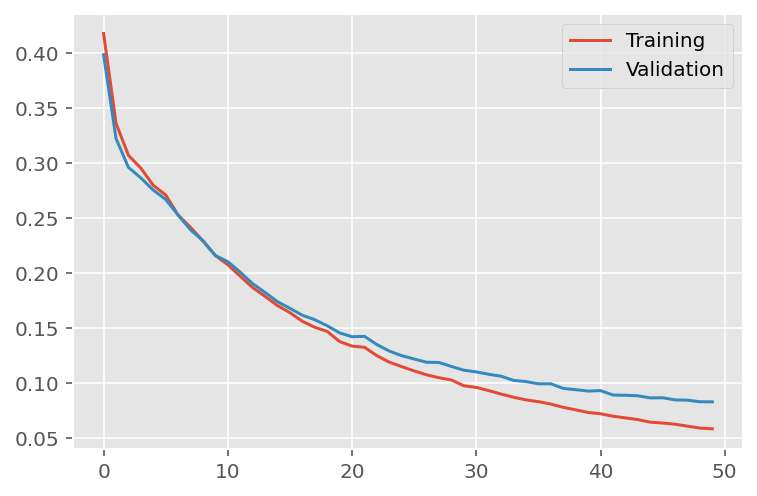

In [6]:
learning_rate = 0.05
batch_size = 32
batches = -(-m // batch_size)
epochs = 50

# initialization
params = { "W1": np.random.uniform(-1, 1, size=(300,784))* np.sqrt(1. / 784),
           "b1": np.zeros(shape=(300,1)) * np.sqrt(1. / 784),
           "W2": np.random.uniform(-1, 1, size=(10,300)) * np.sqrt(1. / 300),
           "b2": np.zeros(shape=(10,1)) * np.sqrt(1. / 300)}
train_cost_list = []
test_cost_list = []
# train
for i in range(epochs):

    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]

    for j in range(batches):

        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        cache = forward_pass_tensor(X, params)
        grads = back_propagate(X, Y, params, cache)

        params["W1"] = params["W1"] - learning_rate * grads["dW1"]
        params["b1"] = params["b1"] - learning_rate * grads["db1"]
        params["W2"] = params["W2"] - learning_rate * grads["dW2"]
        params["b2"] = params["b2"] - learning_rate * grads["db2"]

    cache = forward_pass_tensor(X_train, params)
    train_cost = compute_loss(Y_train, cache["A2"])
    train_cost_list.append(train_cost)
    cache = forward_pass_tensor(X_test, params)
    test_cost = compute_loss(Y_test, cache["A2"])
    test_cost_list.append(test_cost)
    print("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

cache = forward_pass_tensor(X_test, params)
predictions = np.argmax(cache["A2"], axis=0)
labels = np.argmax(Y_test, axis=0)
print(classification_report(predictions, labels))


plt.plot(train_cost_list, label='Training')
plt.plot(test_cost_list, label='Validation')
plt.legend()
plt.show()

### Question 7
Train the network on MNIST and plot the loss of each batch or instance against the timestep. This is called a learning curve or a loss curve. You can achieve this easily enough with a library like matplotlib in a jupyter notebook, or you can install a specialized tool like tensorboard. We'll leave that up to you.

We will investigate how well this network can learn if we limit it to 5 epochs. Do the following experiments:
1. Compare the training loss per epoch to the validation loss per epoch. What does the difference tell you?
2. Run the SGD method multiple times (at least 3) and plot an average and a standard deviation of the objective value3 in each iteration (e.g., see : here). What does this tell you?

In [7]:
def load_mnist_v2(fin=False):
    (x_train, y_train), (x_val, y_val), input_shape = load_mnist(final=fin)
    x_train = x_train / 255
    x_val = x_val / 255
    
    return (x_train, y_train), (x_val, y_val)

In [8]:
def tuning_alpha(alpha, epochs=5, n_its=3, fin=False):
    print('alpha: ', alpha)
    iter = {'train': [], 'val': []}
    for k in range(n_its):
        (x_train, y_train), (x_val, y_val) = load_mnist_v2(fin)

        learning_rate = alpha
        batch_size = 32
        batches = -(-m // batch_size)

        # initialization
        params = { "W1": np.random.uniform(-1, 1, size=(300,784))* np.sqrt(1. / 784),
                "b1": np.zeros(shape=(300,1)) * np.sqrt(1. / 784),
                "W2": np.random.uniform(-1, 1, size=(10,300)) * np.sqrt(1. / 300),
                "b2": np.zeros(shape=(10,1)) * np.sqrt(1. / 300)}
        
        train_cost_list = []
        test_cost_list = []
        
        # train
        for i in range(epochs):

            permutation = np.random.permutation(X_train.shape[1])
            X_train_shuffled = X_train[:, permutation]
            Y_train_shuffled = Y_train[:, permutation]

            for j in range(batches):

                begin = j * batch_size
                end = min(begin + batch_size, X_train.shape[1] - 1)
                X = X_train_shuffled[:, begin:end]
                Y = Y_train_shuffled[:, begin:end]
                m_batch = end - begin

                cache = forward_pass_tensor(X, params)
                grads = back_propagate(X, Y, params, cache)

                params["W1"] = params["W1"] - learning_rate * grads["dW1"]
                params["b1"] = params["b1"] - learning_rate * grads["db1"]
                params["W2"] = params["W2"] - learning_rate * grads["dW2"]
                params["b2"] = params["b2"] - learning_rate * grads["db2"]

            cache = forward_pass_tensor(X_train, params)
            train_cost = compute_loss(Y_train, cache["A2"])
            train_cost_list.append(train_cost)
            cache = forward_pass_tensor(X_test, params)
            test_cost = compute_loss(Y_test, cache["A2"])
            test_cost_list.append(test_cost)
            print("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

        cache = forward_pass_tensor(X_test, params)
        predictions = np.argmax(cache["A2"], axis=0)
        labels = np.argmax(Y_test, axis=0)
        # print(classification_report(predictions, labels))
        
        iter['train'].append(train_cost_list)
        iter['val'].append(test_cost_list)
        print(train_cost_list, test_cost_list)

    plt.plot(train_cost_list, label='Training')
    plt.plot(test_cost_list, label='Validation')
    plt.legend()
    plt.show()

    # print(iter)
    return iter, labels, predictions

3. Run the SGD with different learning rates (e.g., 0.001, 0.003, 0.01, 0.03). Analyze how the learning rate value influences the final performance.

alpha:  0.05
Epoch 1: training cost = 0.40701774876599517, test cost = 0.3882610069827354
Epoch 2: training cost = 0.3353846930988272, test cost = 0.3209562413579987
Epoch 3: training cost = 0.30704552106142247, test cost = 0.2993135705059431
Epoch 4: training cost = 0.2946183612338429, test cost = 0.28550890462878337
Epoch 5: training cost = 0.2718911750579199, test cost = 0.26728662375055495
[0.40701774876599517, 0.3353846930988272, 0.30704552106142247, 0.2946183612338429, 0.2718911750579199] [0.3882610069827354, 0.3209562413579987, 0.2993135705059431, 0.28550890462878337, 0.26728662375055495]
Epoch 1: training cost = 0.40966636954189534, test cost = 0.39288583773767677
Epoch 2: training cost = 0.33170447499706024, test cost = 0.3182978703940136
Epoch 3: training cost = 0.3063491800021981, test cost = 0.29786702160777706
Epoch 4: training cost = 0.2896899814955421, test cost = 0.28454190447714284
Epoch 5: training cost = 0.2731660055592246, test cost = 0.2682195880013333
[0.409666369

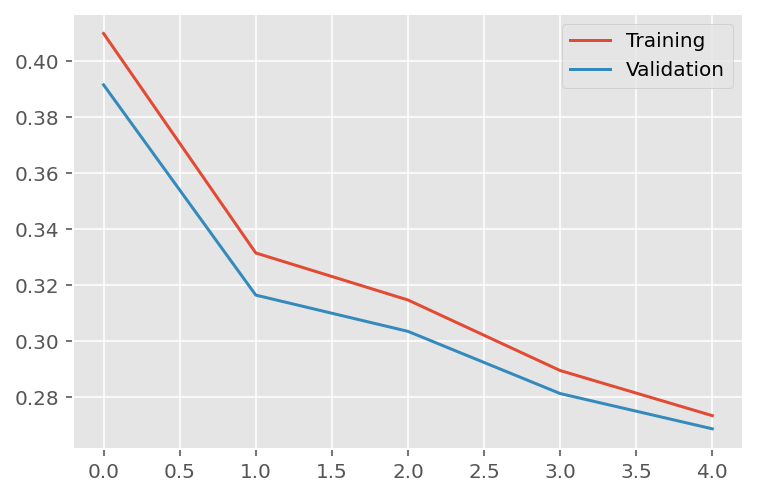

alpha:  0.01
Epoch 1: training cost = 1.2008672043532695, test cost = 1.1842264495579238
Epoch 2: training cost = 0.6710584343811765, test cost = 0.6530449203231289
Epoch 3: training cost = 0.5162374247941843, test cost = 0.49866672947838764
Epoch 4: training cost = 0.4458179317329886, test cost = 0.4280238537004338
Epoch 5: training cost = 0.4060018949284907, test cost = 0.38917057258325294
[1.2008672043532695, 0.6710584343811765, 0.5162374247941843, 0.4458179317329886, 0.4060018949284907] [1.1842264495579238, 0.6530449203231289, 0.49866672947838764, 0.4280238537004338, 0.38917057258325294]
Epoch 1: training cost = 1.1941401575949415, test cost = 1.175280637116007
Epoch 2: training cost = 0.6652826542870892, test cost = 0.6473066865648104
Epoch 3: training cost = 0.5118560276237512, test cost = 0.4946742035627471
Epoch 4: training cost = 0.44354546236954245, test cost = 0.42632772064010716
Epoch 5: training cost = 0.4048953036727439, test cost = 0.388490392438712
[1.1941401575949415, 

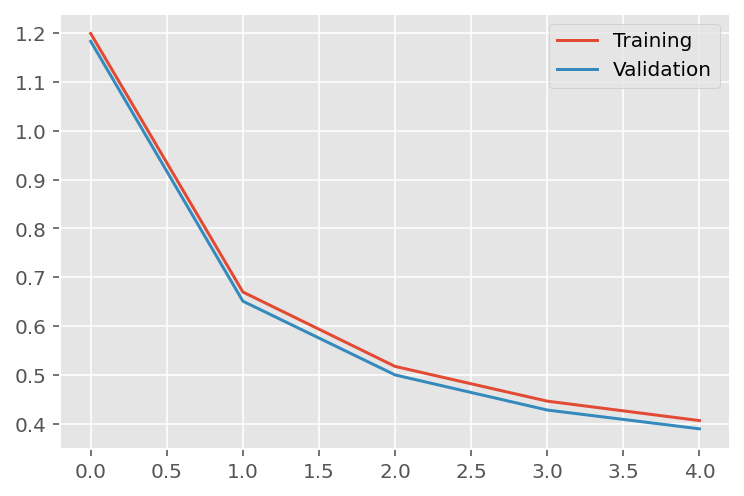

alpha:  0.001
Epoch 1: training cost = 2.2438423639191396, test cost = 2.243313719504041
Epoch 2: training cost = 2.1752755373047883, test cost = 2.17316970643751
Epoch 3: training cost = 2.0907772421327446, test cost = 2.086869029895533
Epoch 4: training cost = 1.9849155387038895, test cost = 1.9789921124200145
Epoch 5: training cost = 1.8570296509936313, test cost = 1.8483712560812928
[2.2438423639191396, 2.1752755373047883, 2.0907772421327446, 1.9849155387038895, 1.8570296509936313] [2.243313719504041, 2.17316970643751, 2.086869029895533, 1.9789921124200145, 1.8483712560812928]
Epoch 1: training cost = 2.24015686736671, test cost = 2.2391601243017822
Epoch 2: training cost = 2.1701090816539, test cost = 2.1681141393856502
Epoch 3: training cost = 2.0846304550649304, test cost = 2.0803570243128244
Epoch 4: training cost = 1.9767101199165538, test cost = 1.9706216674691661
Epoch 5: training cost = 1.8480572978103496, test cost = 1.8397975244967868
[2.24015686736671, 2.1701090816539, 2

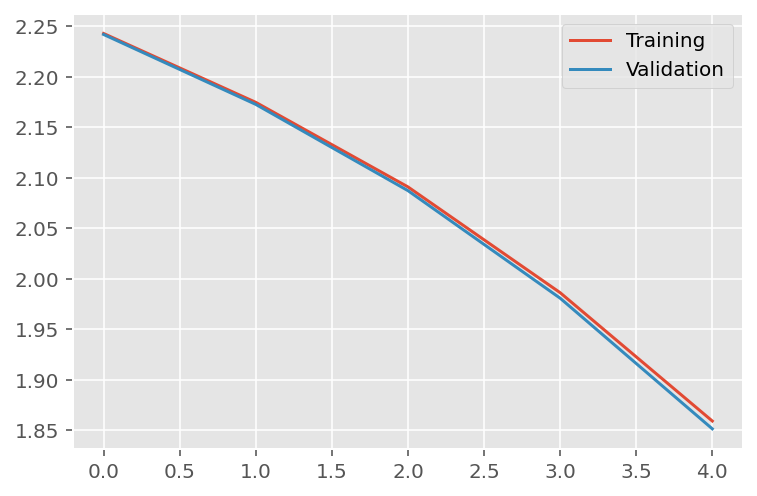

In [9]:
iter05, l05, p05 = tuning_alpha(0.05)
iter01, l01, p01 = tuning_alpha(0.01)
iter001, l001, p001 = tuning_alpha(0.001)

In [10]:
#mean and std for train and test with different alphas
m_tr05 = np.asarray(iter05['train']).mean(axis=0)
sd_tr05 = np.asarray(iter05['train']).std(axis=0)
m_te05 = np.asarray(iter05['val']).mean(axis=0)
sd_te05 = np.asarray(iter05['val']).std(axis=0)

m_tr01 = np.asarray(iter01['train']).mean(axis=0)
sd_tr01 = np.asarray(iter01['train']).std(axis=0)
m_te01 = np.asarray(iter01['val']).mean(axis=0)
sd_te01 = np.asarray(iter01['val']).std(axis=0)

m_tr001 = np.asarray(iter001['train']).mean(axis=0)
sd_tr001 = np.asarray(iter001['train']).std(axis=0)
m_te001 = np.asarray(iter001['val']).mean(axis=0)
sd_te001 = np.asarray(iter001['val']).std(axis=0)

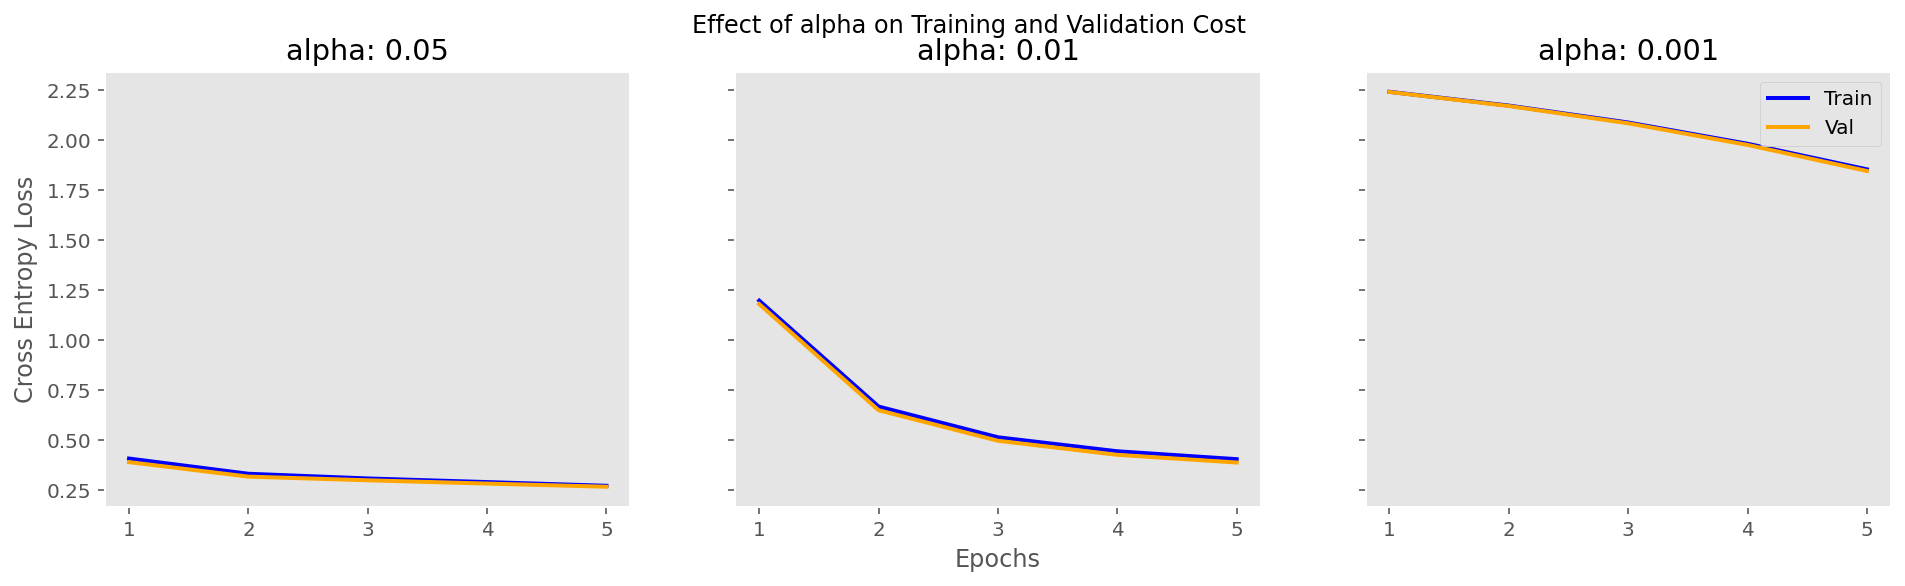

In [20]:
t = np.arange(1, 6)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16, 4))
# fig, ax2 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(8, 8))

ax0.plot(t, m_tr05, lw=2, label='Train', color='blue')
ax0.plot(t, m_te05, lw=2, label='Val', color='orange')
ax0.fill_between(t, m_tr05+sd_tr05, m_tr05-sd_tr05, facecolor='blue', alpha=0.5)
ax0.fill_between(t, m_te05+sd_te05, m_te05-sd_te05, facecolor='orange', alpha=0.5)
ax0.set_title(r'alpha: 0.05')

ax1.plot(t, m_tr01, lw=2, label='Train', color='blue')
ax1.plot(t, m_te01, lw=2, label='Val', color='orange')
ax1.fill_between(t, m_tr01+sd_tr01, m_tr01-sd_tr01, facecolor='blue', alpha=0.5)
ax1.fill_between(t, m_te01+sd_te01, m_te01-sd_te01, facecolor='orange', alpha=0.5)
ax1.set_title(r'alpha: 0.01')

ax2.plot(t, m_tr001, lw=2, label='Train', color='blue')
ax2.plot(t, m_te001, lw=2, label='Val', color='orange')
ax2.fill_between(t, m_tr001+sd_tr001, m_tr001-sd_tr001, facecolor='blue', alpha=0.5)
ax2.fill_between(t, m_te001+sd_te001, m_te001-sd_te001, facecolor='orange', alpha=0.5)
ax2.set_title(r'alpha: 0.001')

ax2.legend(loc='upper right')
ax1.set_xlabel('Epochs')
ax0.set_ylabel('Cross Entropy Loss')
ax0.grid()
ax1.grid()
ax2.grid()


fig.suptitle('Effect of alpha on Training and Validation Cost')
plt.savefig('effects_alpha_cost_all.png', dpi=300)
plt.show()

4. Based on these experiments, choose a final set of hyperparameters, load the full training data with the canonical test set, train your model with the chosen hyperparameters and report the accuracy you get.

In [12]:
f_iter, f_lab, f_pred = tuning_alpha(0.05, fin=True)

ax = plt.axes()
sns.heatmap(confusion_matrix(f_lab, f_pred),fmt="d", annot=True, annot_kws={"size": 12}, ax=ax)

ax.set_title('Confusion Matrix alpha = 0.05', fontsize=20)
plt.show()

alpha:  0.05
Epoch 1: training cost = 0.42097411175602006, test cost = 0.3995307099213762
Epoch 2: training cost = 0.33842930781783365, test cost = 0.32683709708752123
Epoch 3: training cost = 0.306612431887565, test cost = 0.2971941370400792
Epoch 4: training cost = 0.2917581460160389, test cost = 0.2825622648008884
Epoch 5: training cost = 0.27200066112909393, test cost = 0.26686782874262993
[0.42097411175602006, 0.33842930781783365, 0.306612431887565, 0.2917581460160389, 0.27200066112909393] [0.3995307099213762, 0.32683709708752123, 0.2971941370400792, 0.2825622648008884, 0.26686782874262993]
Epoch 1: training cost = 0.4083671745558464, test cost = 0.38960637030514866
Epoch 2: training cost = 0.34054569532395806, test cost = 0.32801760851927914
Epoch 3: training cost = 0.30378578503768666, test cost = 0.2941543437811371
Epoch 4: training cost = 0.2871158247870269, test cost = 0.2811654638443521
Epoch 5: training cost = 0.27760917973917665, test cost = 0.27531914780690825
[0.40836717

KeyboardInterrupt: 